In [ ]:
# %matplotlib widget

import numpy as np
import scipy
import matplotlib.pyplot as plt

from receiver import Receiver802154
from filters import simple_squelch, add_white_gaussian_noise
from demodulation import demodulate_frequency, symbol_sync, binary_slicer
from data_io import read_iq_data
from visualisation import plot_complex_time, plot_periodograms, plot_payload
from modulation import half_sine_fir_taps
from packet_utils import preamble_detection_802154, correlate_access_code, map_nibbles_to_chips

plt.close("all")

# Testing matched filtering on demodulation process

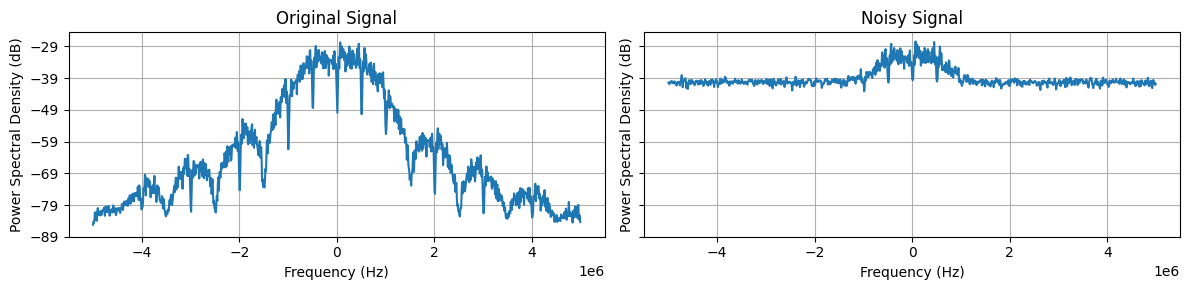

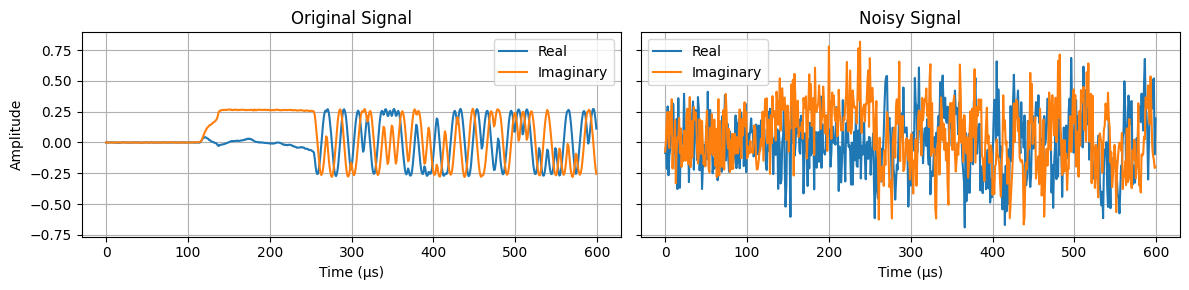

In [37]:
fs = 10e6  # Hz
samples_per_chip = 5  # Samples per chip, 2 Mchip/s, but 1 Msym/s QPSK
samples_per_symbol = 2 * samples_per_chip
filename = "802154_0dBm.dat"  # Open BLE file
iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")
fsk_deviation_802154: float = 500e3  # Hz, when interpreting HSS O-QPSK as MSK

noise_power = -9
iq_samples_noisy = add_white_gaussian_noise(iq_samples, noise_power)

figsize = (12, 3)
plot_periodograms(
    [iq_samples, iq_samples_noisy],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=figsize,
    NFFT=1024,
    horizontal=True,
)
time_interval = (6800, 7400)
plot_complex_time(
    [iq_samples[time_interval[0] : time_interval[1]], iq_samples_noisy[time_interval[0] : time_interval[1]]],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=figsize,
    horizontal=True,
)

## Demodulation process at receiver
Applying HSS matched filtering before frequency demodulating and rectanguar FIR filtering after frequency demodulating yields best results

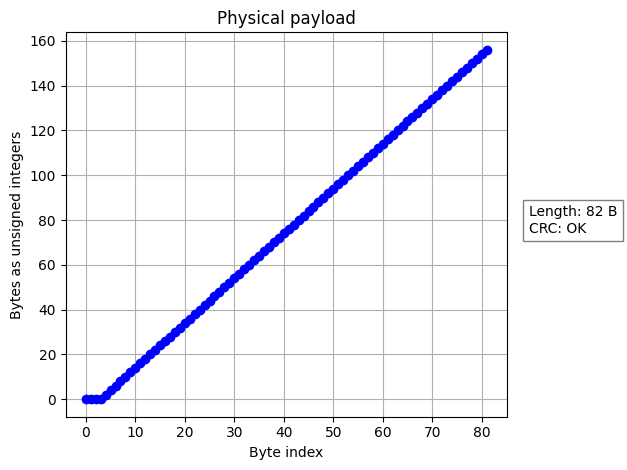

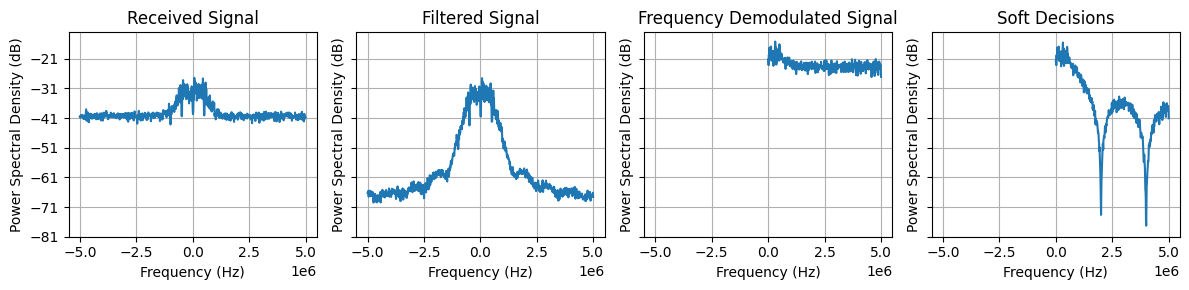

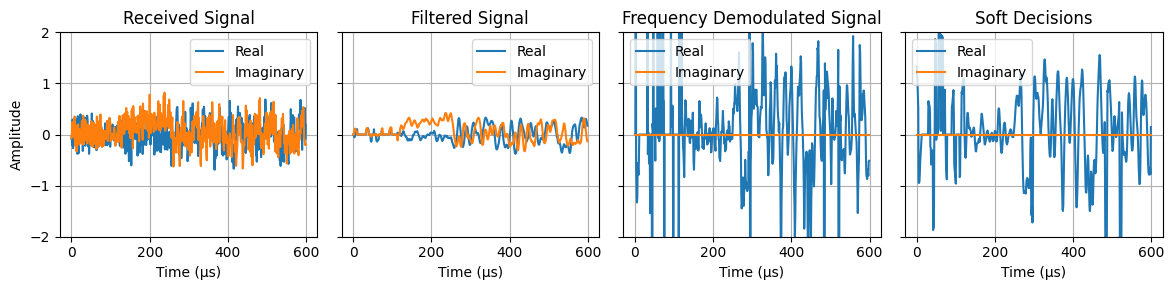

In [38]:
match_filter_before_frequency = True
match_filter_after_frequency = True
if match_filter_before_frequency:
    # Matched filtering (Half Sine FIR taps)
    hss_taps = half_sine_fir_taps(samples_per_symbol)
    hss_taps /= np.sum(hss_taps)  # Unitary gain
    iq_samples_filtered = scipy.signal.convolve(iq_samples_noisy, hss_taps, mode="same")
else:
    iq_samples_filtered = iq_samples_noisy

# Squelch
squelch_threshold = 1e-1
iq_samples_filtered = simple_squelch(iq_samples_filtered, threshold=squelch_threshold)

# Frequency demodulation
freq_samples = demodulate_frequency(iq_samples_filtered, gain=(fs) / (2 * np.pi * fsk_deviation_802154))

if match_filter_after_frequency:
    # Matched filtering (Rectangular FIR taps, HSS before differentiation -> rectangular after differentiation)
    rect_taps = np.ones(samples_per_chip)
    rect_taps /= np.sum(rect_taps)  # Unitary gain
    matched_filtered = scipy.signal.convolve(freq_samples, rect_taps, mode="same")
else:
    matched_filtered = freq_samples


# Symbol synchronisation
bit_samples = symbol_sync(matched_filtered, sps=samples_per_chip)
bit_samples = binary_slicer(bit_samples)
receiver_802154 = Receiver802154(fs=fs)

# ---- Plots ----
received_packets: list[dict] = receiver_802154.process_phy_packet(bit_samples)
if received_packets:
    plot_payload(received_packets[0])

plot_periodograms(
    [
        iq_samples_noisy,
        iq_samples_filtered,
        freq_samples,
        matched_filtered,
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal",
        "Frequency Demodulated Signal",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    NFFT=1024,
    horizontal=True,
)

plot_complex_time(
    [
        iq_samples_noisy[time_interval[0] : time_interval[1]],
        iq_samples_filtered[time_interval[0] : time_interval[1]],
        freq_samples[time_interval[0] : time_interval[1]],
        matched_filtered[time_interval[0] : time_interval[1]],
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal",
        "Frequency Demodulated Signal",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    ylim=(-2, 2),
    horizontal=True,
)

## Band-pass Based Matched Filtering

Apply band-pass matched filtering to the expected frequency at binary 1 and the expected frequency at binary 0 (centre frequency $ \pm \Delta_{FSK} = 500$ kHz). Compare the squared magnitudes of the resulting complex convolution for soft decision-making.

Based on:  
- [FSK Signals Demodulation – WJ Tech Notes](https://www.rfcafe.com/references/articles/wj-tech-notes/fsk-signals-demodulation-v7-5.pdf)  
- [FSK Demodulation & Bit Timing Recovery – DSP Stack Exchange](https://dsp.stackexchange.com/questions/30793/fsk-demodulation-bit-timing-recovery)  



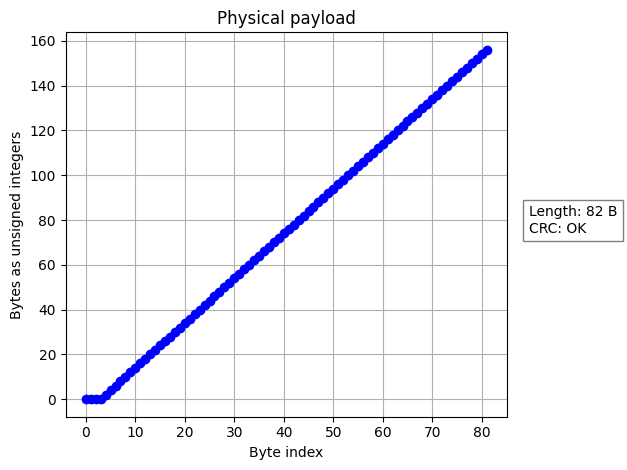

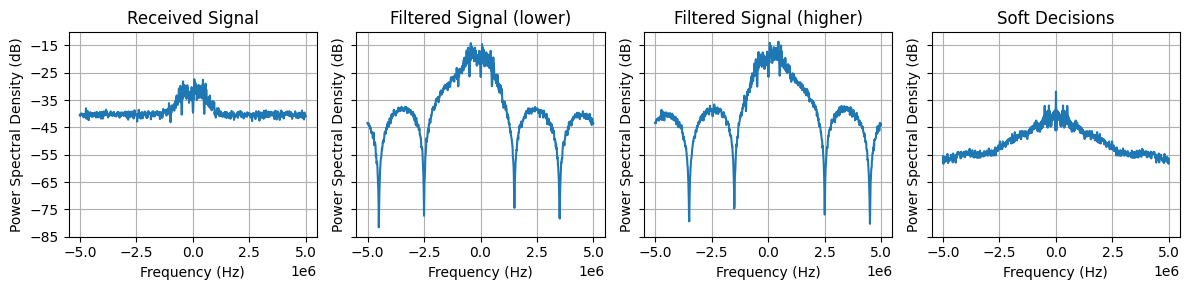

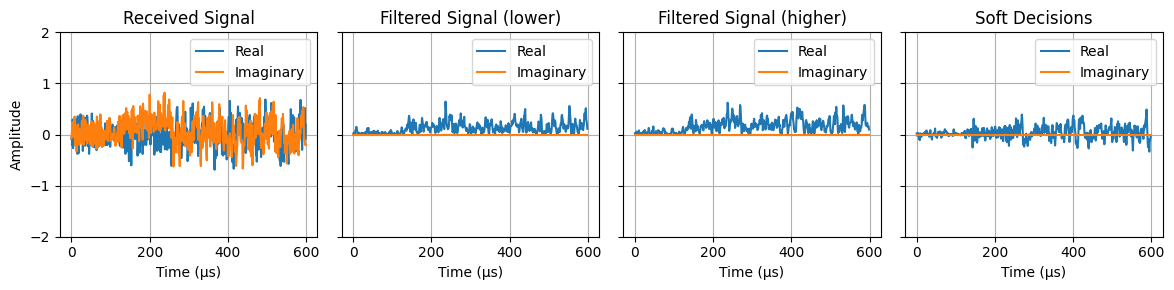

In [39]:
# (repeating code for clarity)
# Matched filtering (Rectangular FIR taps, HSS before differentiation -> rectangular after differentiation)
rect_taps = np.ones(samples_per_chip)

complex_exp = np.exp(1j * 2 * np.pi * fsk_deviation_802154 * np.arange(len(rect_taps)) / fs)
rect_bandpass_lower = rect_taps / complex_exp
rect_bandpass_higher = rect_taps * complex_exp

# Band-pass filter (complex signal, complex filter, complex output)
iq_samples_lower = scipy.signal.convolve(iq_samples_noisy, rect_bandpass_lower, mode="same")
iq_samples_higher = scipy.signal.convolve(iq_samples_noisy, rect_bandpass_higher, mode="same")

# Magnitude squared
iq_samples_lower_square = iq_samples_lower * np.conj(iq_samples_lower)
iq_samples_higher_square = iq_samples_higher * np.conj(iq_samples_higher)
iq_samples_lower_square /= np.max(iq_samples_lower_square)
iq_samples_higher_square /= np.max(iq_samples_higher_square)

# Subtract to obtain soft decisions
soft_decisions_subtracted = iq_samples_higher_square - iq_samples_lower_square

# ---- Plots ----
received_packets: list[dict] = receiver_802154.process_phy_packet(bit_samples)
if received_packets:
    plot_payload(received_packets[0])

plot_periodograms(
    [
        iq_samples_noisy,
        iq_samples_lower,
        iq_samples_higher,
        soft_decisions_subtracted,
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal (lower)",
        "Filtered Signal (higher)",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    NFFT=1024,
    horizontal=True,
)

plot_complex_time(
    [
        iq_samples_noisy[time_interval[0] : time_interval[1]],
        iq_samples_lower_square[time_interval[0] : time_interval[1]],
        iq_samples_higher_square[time_interval[0] : time_interval[1]],
        soft_decisions_subtracted[time_interval[0] : time_interval[1]],
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal (lower)",
        "Filtered Signal (higher)",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    ylim=(-2, 2),
    horizontal=True,
)

## New function for IEEE 802.15.4 preamble detection for increased robustness against noise

In [42]:
chip_mapping: np.ndarray = np.array(
    [
        0xE077AE6C,  # 0
        0xCE077AE6,  # 1
        0x6CE077AE,  # 2
        0xE6CE077A,  # 3
        0xAE6CE077,  # 4
        0x7AE6CE07,  # 5
        0x77AE6CE0,  # 6
        0x877AE6CE,  # 7
        0x1F885193,  # 8
        0x31F88519,  # 9
        0x931F8851,  # A
        0x1931F885,  # B
        0x51931F88,  # C
        0x851931F8,  # D
        0x8851931F,  # E
        0x78851931,  # F
    ],
    dtype=np.uint32,
)

chip_samples = binary_slicer(symbol_sync(np.real(soft_decisions_subtracted), samples_per_chip))

# New function: search for 64 chip sequences independently
print(preamble_detection_802154(chip_samples, threshold=12, chip_mapping=chip_mapping))

# Before: search for the entire preamble sequence at once
access_code = map_nibbles_to_chips([0x00, 0x00, 0x00, 0x00, 0xA7], chip_mapping)
print(correlate_access_code(chip_samples, access_code, threshold=12, reduce_mask=True))

# Both functions should return the same, but the new one should be more robust against noise

[1730]
[]
